In [1]:
%pip install git+https://github.com/openai/CLIP.git -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import subprocess
import math

import torch
import torch.nn.functional as F
import numpy as np
import cv2

import clip

from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from tqdm.auto import tqdm

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "ViT-B/32"
model, preprocess = clip.load(model_name, device = device)

test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform = preprocess)
test_loader = DataLoader(test_set, batch_size = 256, shuffle = False, pin_memory = 1)

classes = list(test_set.classes)

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 96.7MiB/s]
100%|██████████| 170M/170M [00:04<00:00, 34.6MB/s]


In [4]:
@torch.no_grad()
def build_text_features(prompts_per_class):
    all_feats = []
    for prompts in prompts_per_class:
        tokens = clip.tokenize(prompts).to(device)
        text_feat = model.encode_text(tokens)                    
        text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True) 
        all_feats.append(text_feat.mean(dim=0))                      
    text_features = torch.stack(all_feats, dim=1)                     
    text_features = text_features / text_features.norm(dim=0, keepdim=True)
    return text_features


prompts_plain = [[c] for c in classes]

prompts_photo = [[f"a photo of a {c}"] for c in classes]

desc_templates = [
    "a pixelated photo of a {}.",
    "a close-up photo of a {}.",
    "a blurry photo of a {}.",
    "a {} in its natural enviorment",
    "a compressed photo of a {}.",
    "a cropped photo of a {}.",
    "an overexposed photo of the {}.",
]
prompts_desc = [[t.format(c) for t in desc_templates] for c in classes]

weights_plain = build_text_features(prompts_plain)
weights_photo = build_text_features(prompts_photo)
weights_desc  = build_text_features(prompts_desc)

def evaluate(weights):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader):
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            img_feat = model.encode_image(imgs)                    
            img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)
            logits = 100.0 * img_feat @ weights                          
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    return 100.0 * correct / total

acc_plain = evaluate(weights_plain)
acc_photo = evaluate(weights_photo)
acc_desc  = evaluate(weights_desc)

print("Zero-shot accuracy on CIFAR-10 (test set, %):")
print(f"  1) plain label         : {acc_plain:6.2f}")
print(f"  2) 'a photo of a {{c}}': {acc_photo:6.2f}")
print(f"  3) descriptive prompts : {acc_desc:6.2f}")

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Zero-shot accuracy on CIFAR-10 (test set, %):
  1) plain label         :  87.37
  2) 'a photo of a {c}':  88.79
  3) descriptive prompts :  89.04


In [5]:
def to_grayscale(img: Image.Image) -> Image.Image:
    return ImageOps.grayscale(img).convert("RGB")

def to_sketch(img: Image.Image, sigma: float = 5.0, rgb: bool = True) -> Image.Image:
    g = np.array(img.convert("L"), dtype=np.uint8)
    inv = 255 - g
    blur = cv2.GaussianBlur(inv, ksize=(0, 0), sigmaX=sigma, sigmaY=sigma)
    base = g.astype(np.float32)
    denom = 255.0 - blur.astype(np.float32)
    denom[denom < 1.0] = 1.0
    sketch = np.clip(base * 255.0 / denom, 0, 255).astype(np.uint8)
    out = Image.fromarray(sketch, mode="L")
    return out.convert("RGB") if rgb else out


def make_clip_transform(stylize_fn=None):
    def _tfm(img: Image.Image):
        if stylize_fn is not None:
            img = stylize_fn(img)
        return preprocess(img)
    return _tfm

def make_loader(stylize_fn=None, batch_size=256):
    ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=make_clip_transform(stylize_fn))
    return DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

loader_orig     = make_loader(None)
loader_gray     = make_loader(to_grayscale)
loader_sketch   = make_loader(lambda im: to_sketch(im, sigma=5.0))

cifar10_classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
def _article(n): return "an" if n[0].lower() in "aeiou" else "a"
prompts = [f"a photo of {_article(n)} {n}" for n in cifar10_classes]

with torch.no_grad():
    tokens = clip.tokenize(prompts).to(device)
    text_feats = model.encode_text(tokens)               
    text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
    text_feats = text_feats.T                             

@torch.no_grad()
def eval_loader(loader):
    correct, total = 0, 0
    for imgs, labels in loader:
        imgs   = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        img_feats = model.encode_image(imgs)              
        img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
        logits = 100.0 * (img_feats @ text_feats)        
        preds  = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)
    return 100.0 * correct / total

acc_gray   = eval_loader(loader_gray)
acc_sketch = eval_loader(loader_sketch)

print("CLIP ViT-B/32 zero-shot accuracy on CIFAR-10 (test):")
print(f"  Grayscale: {acc_gray:6.2f}%")
print(f"  Sketch   : {acc_sketch:6.2f}%")


CLIP ViT-B/32 zero-shot accuracy on CIFAR-10 (test):
  Grayscale:  72.93%
  Sketch   :  45.33%


Mean conf Q→I: 0.7626953125  Mean conf I→Q: 0.8095703125
Query→Image top-1: 100.0%   top-5: 100.0%  (over 10 queries)
Image→Text top-1: 95.0%   top-5: 100.0%  (over 20 images)

query → image:
- a photo of an airplane    → pred=airplane    | true=airplane    ✓
- a photo of an automobile  → pred=automobile  | true=automobile  ✓
- a photo of a bird         → pred=bird        | true=bird        ✓
- a photo of a cat          → pred=cat         | true=cat         ✓
- a photo of a deer         → pred=deer        | true=deer        ✓
- a photo of a dog          → pred=dog         | true=dog         ✓
- a photo of a frog         → pred=frog        | true=frog        ✓
- a photo of a horse        → pred=horse       | true=horse       ✓
- a photo of a ship         → pred=ship        | true=ship        ✓
- a photo of a truck        → pred=truck       | true=truck       ✓

image → text:
- img[ 0] true=airplane    → pred: a photo of an airplane (class=airplane)
- img[ 1] true=airplane    → pred: a p

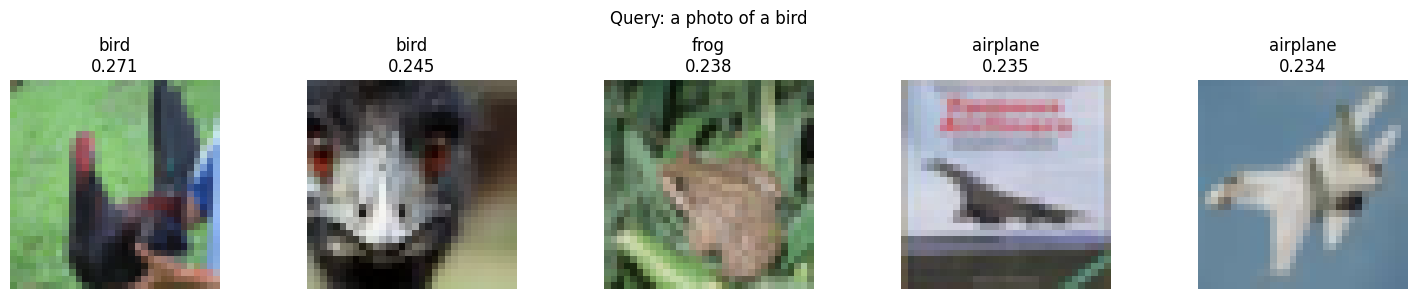

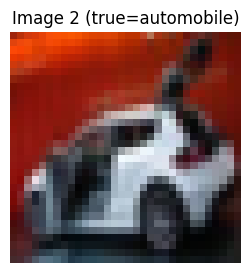

In [6]:
import torch, re
import numpy as np
from PIL import Image
from torchvision import datasets

model.eval()

test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=None)
targets = np.array(test_set.targets)
picked_idxs = np.concatenate([np.where(targets == c)[0][:2] for c in range(10)])

subset_raw   = [Image.fromarray(test_set.data[i]) for i in picked_idxs]
subset_labels = torch.tensor([test_set.targets[i] for i in picked_idxs])
subset_imgs   = torch.stack([preprocess(img) for img in subset_raw]).to(device)

with torch.no_grad():
    img_feats = model.encode_image(subset_imgs)
    img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)

cifar10_classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
queries = [f"a photo of a {n}" if n not in {"airplane","automobile"} else
           f"a photo of an {n}" for n in cifar10_classes]                          

tokens = clip.tokenize(queries).to(device)
with torch.no_grad():
    text_feats = model.encode_text(tokens)
    text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)              

sims     = text_feats @ img_feats.T                                              
sims_rev = img_feats  @ text_feats.T                                               

import torch.nn.functional as F

logits_q2i = 100.0 * sims
logits_i2q = 100.0 * sims_rev
conf_q2i = F.softmax(logits_q2i, dim=1).max(dim=1).values  
conf_i2q = F.softmax(logits_i2q, dim=1).max(dim=1).values 
print("Mean conf Q→I:", conf_q2i.mean().item(), " Mean conf I→Q:", conf_i2q.mean().item())


name_to_id = {n:i for i,n in enumerate(cifar10_classes)}

def q2id(q):
    q = q.lower()
    for n in cifar10_classes:
        if re.search(rf"\b{n}\b", q): return name_to_id[n]
    return None

query_class_ids = [q2id(q) for q in queries]
valid_q_mask    = torch.tensor([cid is not None for cid in query_class_ids], dtype=torch.bool)
valid_q_ids     = torch.tensor([cid for cid in query_class_ids if cid is not None])

top1_img = sims.argmax(dim=1)                             
top5_img = sims.topk(5, dim=1).indices                    
img_cls  = subset_labels.tolist()                        

q2i_top1 = sum(img_cls[top1_img[i].item()] == valid_q_ids[j].item()
               for j,i in enumerate(torch.arange(len(queries))[valid_q_mask]))
q2i_top5 = sum(any(img_cls[k.item()] == valid_q_ids[j].item() for k in top5_img[i])
               for j,i in enumerate(torch.arange(len(queries))[valid_q_mask]))
den_q    = max(1, valid_q_mask.sum().item())
print(f"Query→Image top-1: {100*q2i_top1/den_q:.1f}%   top-5: {100*q2i_top5/den_q:.1f}%  (over {den_q} queries)")

top1_txt = sims_rev.argmax(dim=1)                           # [20]
top5_txt = sims_rev.topk(5, dim=1).indices                  # [20,5]

i2q_top1 = sum(query_class_ids[top1_txt[i].item()] == img_cls[i] for i in range(len(img_cls)))
i2q_top5 = sum(any(query_class_ids[q.item()] == img_cls[i] for q in top5_txt[i]) for i in range(len(img_cls)))
den_i    = len(img_cls)
print(f"Image→Text top-1: {100*i2q_top1/den_i:.1f}%   top-5: {100*i2q_top5/den_i:.1f}%  (over {den_i} images)")

def show_q2i(n=6):
    print("\nquery → image:")
    cnt = 0
    for i,q in enumerate(queries):
        cid = query_class_ids[i]
        if cid is None: continue
        p = top1_img[i].item()
        ok = "✓" if img_cls[p] == cid else "✗"
        print(f"- {q:25s} → pred={cifar10_classes[img_cls[p]]:11s} | true={cifar10_classes[cid]:11s} {ok}")
        cnt += 1
        if cnt >= n: break

def show_i2q(n=6):
    print("\nimage → text:")
    for i in range(min(n, len(img_cls))):
        p = top1_txt[i].item()
        pred_c = query_class_ids[p]
        pred_cname = cifar10_classes[pred_c] if pred_c is not None else "unknown"
        print(f"- img[{i:2d}] true={cifar10_classes[img_cls[i]]:11s} → pred: {queries[p]} (class={pred_cname})")

show_q2i(10)
show_i2q(20)


def q2i_markdown_table(k=6):
    rows = ["| Query | Predicted class | True class | Score |",
            "|---|---|---|---|"]
    shown = 0
    for i, q in enumerate(queries):
        cid = query_class_ids[i]
        if cid is None: continue
        p   = top1_img[i].item()
        pred = cifar10_classes[img_cls[p]]
        true = cifar10_classes[cid]
        score = sims[i, p].item()
        rows.append(f"| {q} | {pred} | {true} | {score:.3f} |")
        shown += 1
        if shown >= k: break
    print("\n".join(rows))

q2i_markdown_table(k=20)


def i2q_markdown_table(k=6):
    rows = ["| Image idx | True class | Predicted query | Pred. class | Score |",
            "|---|---|---|---|---|"]
    for i in range(min(k, len(img_cls))):
        p   = top1_txt[i].item()
        pred_cls_id = query_class_ids[p]
        pred_cls = cifar10_classes[pred_cls_id] if pred_cls_id is not None else "unknown"
        true = cifar10_classes[img_cls[i]]
        score = sims_rev[i, p].item()
        rows.append(f"| {i} | {true} | {queries[p]} | {pred_cls} | {score:.3f} |")
    print("\n".join(rows))

i2q_markdown_table(k=20)


import matplotlib.pyplot as plt

def show_q2i_topk(q_idx, k=5):
    topk = sims[q_idx].topk(k).indices.tolist()
    fig, axes = plt.subplots(1, k, figsize=(3*k, 3))
    for j, ax in enumerate(axes):
        img_idx = topk[j]
        clsname = cifar10_classes[img_cls[img_idx]]
        score   = sims[q_idx, img_idx].item()
        ax.imshow(subset_raw[img_idx]); ax.axis("off")
        ax.set_title(f"{clsname}\n{score:.3f}")
    fig.suptitle(f"Query: {queries[q_idx]}")
    plt.tight_layout()

def show_i2q_topk(i_idx, k=5):
    topk = sims_rev[i_idx].topk(k).indices.tolist()
    plt.figure(figsize=(3,3)); plt.imshow(subset_raw[i_idx]); plt.axis("off")
    plt.title(f"Image {i_idx} (true={cifar10_classes[img_cls[i_idx]]})")
    print(f"\nTop-{k} queries for image {i_idx}:")
    for q in topk:
        qid = query_class_ids[q]
        qname = cifar10_classes[qid] if qid is not None else "unknown"
        print(f"  - {queries[q]}  | class={qname:11s} | score={sims_rev[i_idx, q].item():.3f}")


show_q2i_topk(2, k=5)  # see top-5 images for query 0
show_i2q_topk(2, k=5)  # see image 0 plus top-5 queries printed with scores


In [7]:
import os, random, re, torch, cv2, numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageOps
from torchvision import datasets
import clip
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# -------------------- Config --------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "ViT-B/32"
seed = 27
n_per_class = 100
add_ood_grayscale = True
add_ood_sketch    = True
ood_from_each_class = 30
external_ood_paths = ["/kaggle/input/ood-pngs/OOD_pngs/plane.png", "/kaggle/input/ood-pngs/OOD_pngs/bird.png","/kaggle/input/ood-pngs/OOD_pngs/cat.png","/kaggle/input/ood-pngs/OOD_pngs/car.png","/kaggle/input/ood-pngs/OOD_pngs/dog.png"]

random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

model, preprocess = clip.load(model_name, device=device)
model.eval()

cifar10 = datasets.CIFAR10(root="./data", train=False, download=True)
cifar_classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
targets = np.array(cifar10.targets)


picked_idxs = []
for c in range(10):
    idxs = np.where(targets == c)[0]
    chosen = idxs[:n_per_class] 
    picked_idxs.extend(chosen.tolist())


photos = [Image.fromarray(cifar10.data[i]) for i in picked_idxs]
photo_labels = [targets[i] for i in picked_idxs]
photo_domains = ["photo"] * len(photos)

def to_grayscale(img: Image.Image) -> Image.Image:
    return ImageOps.grayscale(img).convert("RGB")

def to_sketch(img: Image.Image, sigma: float = 5.0, rgb: bool = True) -> Image.Image:

    g = np.array(img.convert("L"), dtype=np.uint8)

    inv = 255 - g

    blur = cv2.GaussianBlur(inv, ksize=(0, 0), sigmaX=sigma, sigmaY=sigma)

    base = g.astype(np.float32)
    denom = 255.0 - blur.astype(np.float32)
    denom[denom < 1.0] = 1.0                      
    sketch = np.clip(base * 255.0 / denom, 0, 255).astype(np.uint8)

    out = Image.fromarray(sketch, mode="L")
    return out.convert("RGB") if rgb else out
    
grays, gray_labels, gray_domains = [], [], []
sketches, sketch_labels, sketch_domains = [], [], []

if add_ood_grayscale or add_ood_sketch:

    for c in range(10):
        idxs = np.where(targets == c)[0][:ood_from_each_class]
        for i in idxs:
            pil = Image.fromarray(cifar10.data[i])
            if add_ood_grayscale:
                grays.append(to_grayscale(pil))
                gray_labels.append(c)
                gray_domains.append("grayscale")
            if add_ood_sketch:
                sketches.append(to_sketch(pil))
                sketch_labels.append(c)
                sketch_domains.append("sketch")


ext_imgs, ext_labels, ext_domains = [], [], []
for p in external_ood_paths:
    try:
        img = Image.open(p).convert("RGB")
        ext_imgs.append(img)

        lower = os.path.basename(p).lower()
        guess = -1
        for ci, cname in enumerate(cifar_classes):
            if re.search(rf"\b{cname}\b", lower):
                guess = ci; break
            if "car" in lower and cname == "automobile": guess = ci
            if ("plane" in lower or "aeroplane" in lower) and cname == "airplane": guess = ci
        #print(guess)
        ext_labels.append(guess)
        ext_domains.append("external")
    except Exception as e:
        print(f"Could not open {p}: {e}")


In [8]:
all_imgs    = photos + grays + sketches + ext_imgs
all_labels  = photo_labels + gray_labels + sketch_labels + ext_labels
all_domains = photo_domains + gray_domains + sketch_domains + ext_domains

print(f"Total images: {len(all_imgs)} "
      f"(photo={len(photos)}, gray={len(grays)}, sketch={len(sketches)}, external={len(ext_imgs)})")


Total images: 1605 (photo=1000, gray=300, sketch=300, external=5)


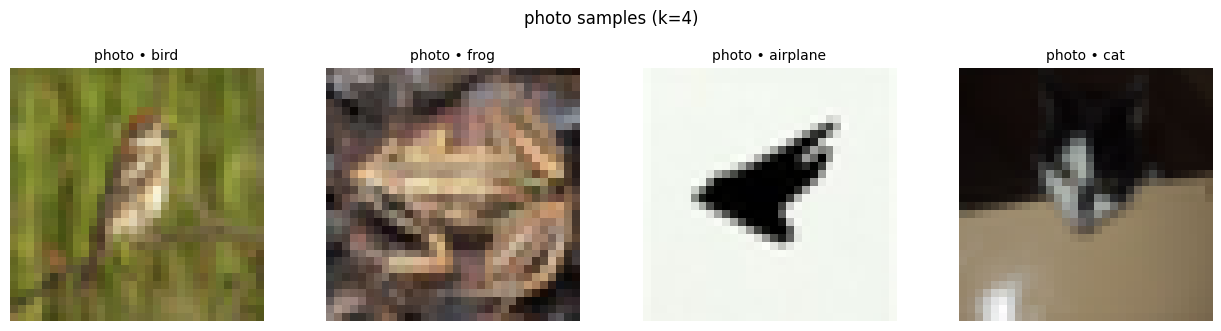

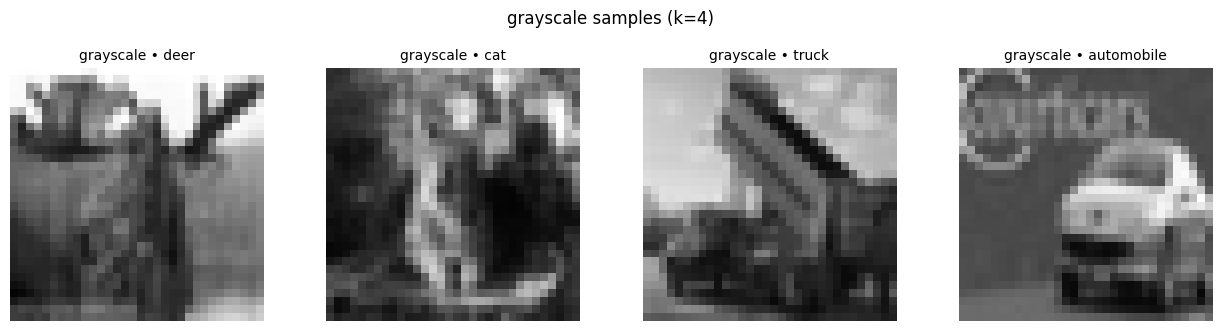

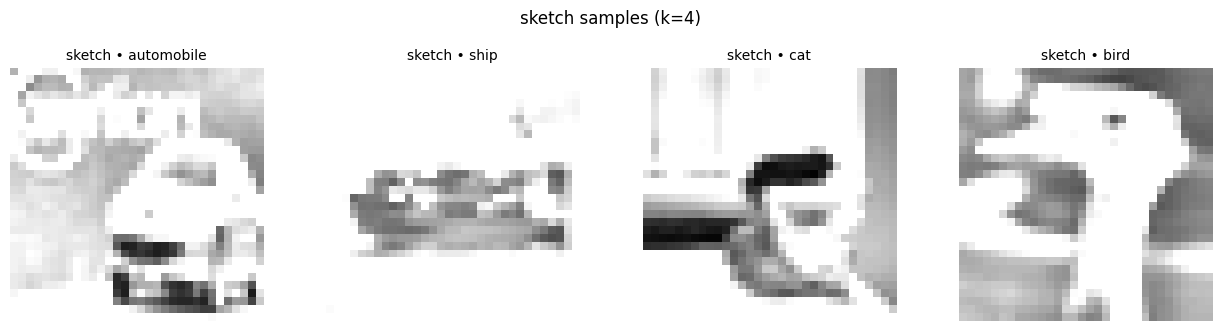

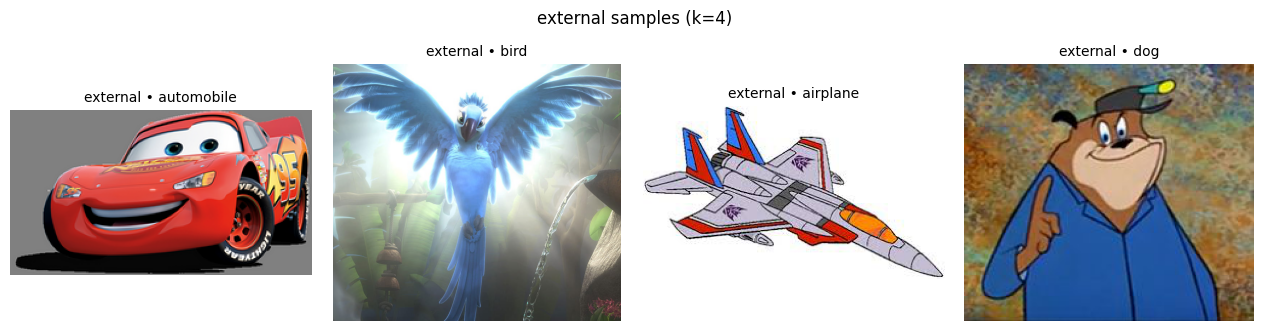

In [9]:


def show_domain_samples(k=5, seed=27):
    rng = np.random.default_rng(seed)
    domains_order = ["photo", "grayscale", "sketch", "external"]

    for dom in domains_order:
        idxs = [i for i, d in enumerate(all_domains) if d == dom]
        if not idxs:
            print(f"[{dom}] no images found.")
            continue

        pick = idxs if len(idxs) <= k else rng.choice(idxs, size=k, replace=False)
        cols = min(5, len(pick))
        rows = math.ceil(len(pick) / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows))
        axes = np.atleast_1d(axes).ravel()

        for ax, i in zip(axes, pick):
            ax.imshow(all_imgs[i])
            ax.axis("off")
            lab = all_labels[i]
            cname = cifar_classes[lab] if (isinstance(lab, (int, np.integer)) and lab >= 0) else "unknown"
            ax.set_title(f"{dom} • {cname}", fontsize=10)

        # hide any unused axes
        for ax in axes[len(pick):]:
            ax.axis("off")

        plt.suptitle(f"{dom} samples (k={len(pick)})", y=1.02, fontsize=12)
        plt.tight_layout()
        plt.show()

# Usage
show_domain_samples(k=4)


In [10]:

def encode_images(img_list):
    batch = torch.stack([preprocess(im) for im in img_list]).to(device)
    with torch.no_grad():
        feats = model.encode_image(batch)
        feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats.detach().cpu().numpy()

embeddings = encode_images(all_imgs) 


def reduce_tsne(X, n=2, perplexity=30, n_iter=1000, seed=27):
    X_init = PCA(n_components=min(50, X.shape[1]), random_state=seed).fit_transform(X)
    ts = TSNE(n_components=n, perplexity=perplexity, n_iter=n_iter, init="pca", random_state=seed)
    return ts.fit_transform(X_init)

tsne_2d = reduce_tsne(embeddings, n=2, perplexity=30, n_iter=1000, seed=seed)


cifar_classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
num_classes = len(cifar_classes)

cmap = plt.get_cmap("tab10")
class_color = {i: cmap(i) for i in range(num_classes)}
unknown_color = "#9e9e9e"

domain_to_marker = {"photo": "o", "grayscale": "s", "sketch": "^", "external": "X"}


In [11]:
def _article(name: str) -> str:
    return "an" if name[0].lower() in "aeiou" else "a"

prompts = [f"a photo of {_article(n)} {n}" for n in cifar_classes]
tokens  = clip.tokenize(prompts).to(device)

with torch.no_grad():
    text_feats = model.encode_text(tokens)                
    text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
    text_feats = text_feats.T                             


def encode_images_torch(img_list):
    batch = torch.stack([preprocess(im) for im in img_list]).to(device)
    with torch.no_grad():
        feats = model.encode_image(batch)                
        feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats

img_feats_t = encode_images_torch(all_imgs)              

logits = 100.0 * (img_feats_t @ text_feats)               
preds  = logits.argmax(dim=1).cpu().numpy()           
labels_np  = np.array(all_labels)                     
domains_np = np.array(all_domains)                    

def masked_acc(pred, true):
    m = (true >= 0)
    if m.sum() == 0: 
        return np.nan, 0
    return float((pred[m] == true[m]).mean()), int(m.sum())


domains_order = ["photo", "grayscale", "sketch", "external"]
print("\nPer-domain zero-shot accuracy (ViT-B/32, prompt='a photo of a/an {class}')")
overall_acc, overall_n = masked_acc(preds, labels_np)
print(f"  Overall: {overall_acc*100:.2f}%  (N={overall_n} with known labels)")

for dom in domains_order:
    mask = (domains_np == dom)
    acc, n = masked_acc(preds[mask], labels_np[mask])
    
    known = (labels_np[mask] >= 0).sum()
    total = mask.sum()
    if np.isnan(acc):
        print(f"  {dom:9s}: n/a (no known labels; total={total}, known={known})")
    else:
        print(f"  {dom:9s}: {acc*100:.2f}%  (N={n}, total={total}, known={known})")



Per-domain zero-shot accuracy (ViT-B/32, prompt='a photo of a/an {class}')
  Overall: 78.57%  (N=1605 with known labels)
  photo    : 90.40%  (N=1000, total=1000, known=1000)
  grayscale: 73.00%  (N=300, total=300, known=300)
  sketch   : 44.33%  (N=300, total=300, known=300)
  external : 100.00%  (N=5, total=5, known=5)


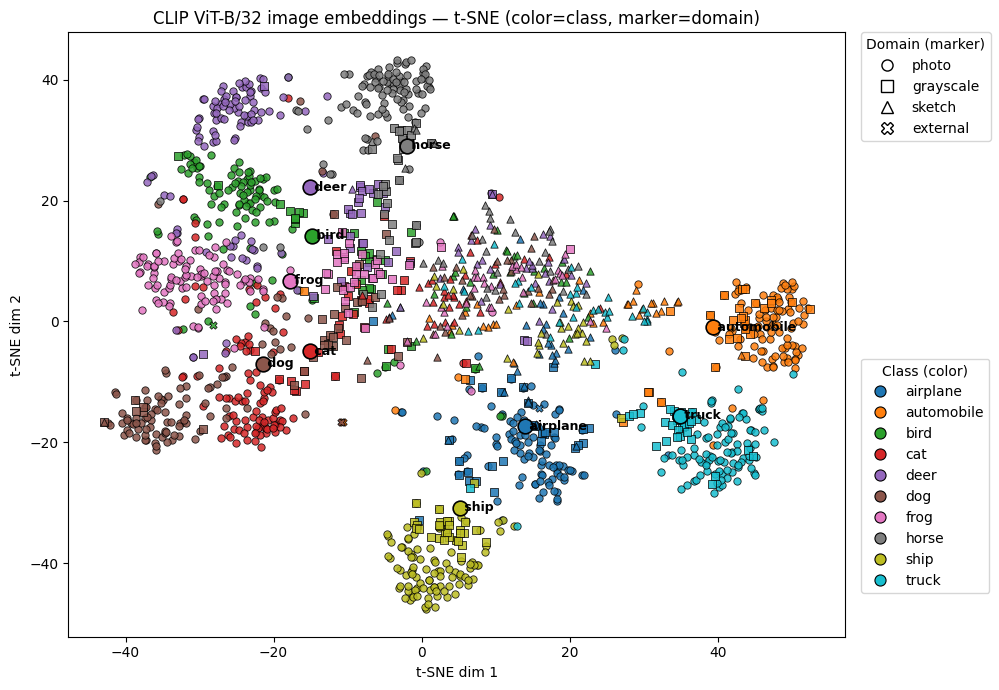

In [12]:


def scatter_tsne(
    Z,
    title="CLIP ViT-B/32 image embeddings — t-SNE (color=class, marker=domain)",
    show_centroids=True,
    point_size=28,          
    point_alpha=0.85,       
    edge_width=0.6         
):

    plt.figure(figsize=(13, 7))
    ax = plt.gca()


    for (x, y), lab, dom in zip(Z, all_labels, all_domains):
        color  = class_color.get(lab, unknown_color)
        marker = domain_to_marker.get(dom, "o")
        ax.scatter(
            x, y,
            c=[color],
            marker=marker,
            s=point_size,
            edgecolors="black",
            linewidths=edge_width,
            alpha=point_alpha
        )


    if show_centroids:
        import numpy as np
        for cid in range(num_classes):
            idxs = [i for i,lab in enumerate(all_labels) if lab == cid]
            if not idxs: 
                continue
            xy = Z[idxs]
            cx, cy = float(xy[:,0].mean()), float(xy[:,1].mean())
            ax.scatter(
                cx, cy,
                c=[class_color[cid]],
                marker="o",
                s=point_size*4,
                edgecolors="black",
                linewidths=1.2,
                alpha=1.0,
                zorder=3
            )
            ax.text(
                cx, cy,
                f" {cifar_classes[cid]}",
                fontsize=9, weight="bold",
                va="center", ha="left",
                color="black",
                zorder=4
            )


    domain_handles = [
        Line2D([0],[0], marker=m, color="black", markerfacecolor="white",
               markeredgewidth=1.0, linestyle="None", markersize=8, label=d)
        for d,m in domain_to_marker.items()
    ]

    class_handles = [
        Line2D([0],[0], marker="o", color=class_color[i], linestyle="None",
               markeredgecolor="black", markeredgewidth=0.8, markersize=8,
               label=cifar_classes[i])
        for i in range(num_classes)
    ]
    if any(lab not in class_color for lab in all_labels):
        class_handles.append(
            Line2D([0],[0], marker="o", color=unknown_color, linestyle="None",
                   markeredgecolor="black", markeredgewidth=0.8, markersize=8,
                   label="unknown")
        )


    lg1 = ax.legend(domain_handles, [h.get_label() for h in domain_handles],
                    title="Domain (marker)", loc="upper left",
                    bbox_to_anchor=(1.02, 1.0), borderaxespad=0.)
    ax.add_artist(lg1)
    ax.legend(class_handles, [h.get_label() for h in class_handles],
              title="Class (color)", loc="upper left",
              bbox_to_anchor=(1.02, 0.46), borderaxespad=0., ncol=1)

    ax.set_title(title)
    ax.set_xlabel("t-SNE dim 1")
    ax.set_ylabel("t-SNE dim 2")


    plt.tight_layout(rect=[0.0, 0.0, 0.78, 1.0])
    plt.show()


scatter_tsne(tsne_2d)


In [13]:

@torch.no_grad()
def eval_clip(image_path, classes, model, preprocess, device=None, topk=5, logit_scale=100.0, prompt_type = 0):
    
    device = device or next(model.parameters()).device
    model.eval()

    img = Image.open(image_path).convert("RGB")
    img_t = preprocess(img).unsqueeze(0).to(device)
    img_feat = model.encode_image(img_t)
    img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True) 


    if (prompt_type == 1):
        prompts = [f"a photo with the texture of a {c}" for c in classes]
    if(prompt_type == 2):
        prompts = [f"a photo with the shape of a  {c}" for c in classes]
    else:
        prompts = [f"a photo of a {c}" for c in classes]
    
    tokens = clip.tokenize(prompts).to(device)
    text_feat = model.encode_text(tokens)                       
    text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
    text_feat = text_feat.T                                     


    cos = (img_feat @ text_feat).squeeze(0)                     
    logits = logit_scale * cos
    probs = F.softmax(logits, dim=-1)


    k = min(topk, len(classes))
    topk_vals, topk_idx = probs.topk(k)
    pred_idx = int(topk_idx[0].item())
    pred_name = classes[pred_idx]
    confidence = float(topk_vals[0].item())
    margin = float((logits.topk(2).values.diff()[0]).item()) if len(classes) > 1 else float("nan")
    entropy = float(-(probs * (probs + 1e-12).log()).sum().item())

    return {
        "image_path": image_path,
        "prediction": pred_name,
        "confidence": confidence,
        "topk": [(classes[int(i.item())], float(v.item())) for v, i in zip(topk_vals, topk_idx)],
        "cosine_similarities": {classes[i]: float(cos[i].item()) for i in range(len(classes))},
        "logits": {classes[i]: float(logits[i].item()) for i in range(len(classes))},
        "probabilities": {classes[i]: float(probs[i].item()) for i in range(len(classes))},
        "top1_top2_margin": margin,
        "entropy": entropy,
    }


classes = ["cat","elephant"]
OOD_example1 = "/kaggle/input/ood-pngs/OOD_pngs/elephant_cat.png"

out = eval_clip(OOD_example1, classes, model, preprocess, topk=2)
print("simple cat vs elephant")
print(out["prediction"], out["confidence"])
print(out["topk"])

classes = ["cat","elephant","car", "dog", "clock"]
OOD_example1 = "/kaggle/input/ood-pngs/OOD_pngs/elephant_cat.png"

out = eval_clip(OOD_example1, classes, model, preprocess, topk=5)
print(" cat vs elephant - adding other classes for noise")
print(out["prediction"], out["confidence"])
print(out["topk"])

classes = ["cat","elephant"]
OOD_example1 = "/kaggle/input/ood-pngs/OOD_pngs/elephant_cat.png"

out = eval_clip(OOD_example1, classes, model, preprocess, topk=2, prompt_type = 1)
print("cat vs elephant - modifying prompt style to force texture bias")
print(out["prediction"], out["confidence"])
print(out["topk"])
classes = ["cat","elephant"]
OOD_example1 = "/kaggle/input/ood-pngs/OOD_pngs/elephant_cat.png"

out = eval_clip(OOD_example1, classes, model, preprocess, topk=2, prompt_type = 2)
print("cat vs elephant - modifying prompt style to force shape bias")
print(out["prediction"], out["confidence"])
print(out["topk"])



classes = ["plane", "apple"]
OOD_example1 = "/kaggle/input/ood-pngs/fruit_plane.png"

out = eval_clip(OOD_example1, classes, model, preprocess, topk=2)
print("Simple Plane vs apple")
print(out["prediction"], out["confidence"])
print(out["topk"])


classes = ["car","sheep"]
OOD_example1 = "/kaggle/input/ood-pngs/sheep_car.png"

out = eval_clip(OOD_example1, classes, model, preprocess, topk=2)
print("harder example - simple car vs sheep - harder texture to link to sheep")
print(out["prediction"], out["confidence"])
print(out["topk"])


simple cat vs elephant
elephant 0.9560546875
[('elephant', 0.9560546875), ('cat', 0.04400634765625)]
 cat vs elephant - adding other classes for noise
elephant 0.8896484375
[('elephant', 0.8896484375), ('dog', 0.060546875), ('cat', 0.042266845703125), ('car', 0.004184722900390625), ('clock', 0.0032596588134765625)]
cat vs elephant - modifying prompt style to force texture bias
elephant 0.9560546875
[('elephant', 0.9560546875), ('cat', 0.04400634765625)]
cat vs elephant - modifying prompt style to force shape bias
elephant 0.8056640625
[('elephant', 0.8056640625), ('cat', 0.1943359375)]
Simple Plane vs apple
plane 0.9970703125
[('plane', 0.9970703125), ('apple', 0.0029811859130859375)]
harder example - simple car vs sheep - harder texture to link to sheep
car 0.99462890625
[('car', 0.99462890625), ('sheep', 0.0053863525390625)]
